In [ ]:
!pip install tqdm seaborn skillsnetwork scikit-learn==0.24

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 44.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for scikit-learn (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scikit-learn
Failed to build scikit-learn
ERROR: Could not build wheels for scikit-learn, which is required to install pyproject.toml-based projects


# Import libraries

In [ ]:
from functools import reduce
from copy import deepcopy
import tqdm
import numpy as np
from scipy.signal import periodogram
from scipy.stats import binomtest
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
%matplotlib inline

# Float format for pandas display
pd.set_option('display.float_format', lambda x: '%.8f' % x)

# Suppress unneeded warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set(style="darkgrid")

In [ ]:
!pip install skillsnetwork

  Using cached skillsnetwork-0.20.6-py3-none-any.whl (26 kB)
  Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
#@title Import datasets
import skillsnetwork
await skillsnetwork.download_dataset(
    'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0K1YEN/laguardia.csv'
)
laguardia = pd.read_csv('laguardia.csv', dtype='str')

# Import DOW Jones Industrial Average historical data

await skillsnetwork.download_dataset(
    'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0K1YEN/dow_jones.csv'
)
dow = pd.read_csv('dow_jones.csv', dtype='str')

Saved as 'laguardia.csv'


Saved as 'dow_jones.csv'


In [ ]:
dow

,DATE,Open,High,Low,Close,Volume
0,2012-12-31,12938.2,13109.1,12883.9,13104.1,1457.4
1,2012-12-28,13095.1,13095.5,12926.9,12938.1,859.8
2,2012-12-27,13115,13141.7,12964.1,13096.3,1001.6
3,2012-12-26,13138.9,13174.9,13076.9,13114.6,794.1
4,2012-12-25,na,na,na,na,na
...,...,...,...,...,...,...
29212,1901-01-10,na,na,na,49.73,na
29213,1901-01-09,na,na,na,49.47,na
29214,1901-01-08,na,na,na,49.56,na
29215,1901-01-07,na,na,na,49.17,na


In [ ]:
dow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29217 entries, 0 to 29216
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    29217 non-null  object
 1   Open    29217 non-null  object
 2   High    29217 non-null  object
 3   Low     29217 non-null  object
 4   Close   29217 non-null  object
 5   Volume  29217 non-null  object
dtypes: object(6)
memory usage: 1.3+ MB


In [ ]:
laguardia

,DATE,wind,dew_point,temp,pressure,cloud_cover
0,1948-07-01T11:00:00,3.1,20.6,22.8,1015.6,1.0
1,1948-07-01T12:00:00,1.5,20.0,23.3,1015.9,0.875
2,1948-07-01T13:00:00,4.6,20.0,25.0,1016.3,0.25
3,1948-07-01T14:00:00,3.6,19.4,26.7,1016.3,0.0
4,1948-07-01T15:00:00,5.2,17.2,27.8,1016.3,0.0
...,...,...,...,...,...,...
801934,2023-12-31T20:51:00,4.6,-3.9,6.1,1014.5,NaN
801935,2023-12-31T21:00:00,4.6,-3.9,6.1,1014.5,1.0
801936,2023-12-31T21:51:00,5.7,-3.9,6.1,1015.1,NaN
801937,2023-12-31T22:51:00,4.6,-4.4,6.1,1015.3,NaN


In [ ]:
laguardia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801939 entries, 0 to 801938
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   DATE         801939 non-null  object
 1   wind         732509 non-null  object
 2   dew_point    717130 non-null  object
 3   temp         717298 non-null  object
 4   pressure     683501 non-null  object
 5   cloud_cover  646597 non-null  object
dtypes: object(6)
memory usage: 36.7+ MB


In [ ]:
#@title Data preprocessing
# Weather data
laguardia['DATE'] = pd.to_datetime(laguardia.DATE)
laguardia[['wind',
           'dew_point',
           'temp', 'pressure',
           'cloud_cover']] = laguardia[['wind',
           'dew_point',
           'temp', 'pressure',
           'cloud_cover']].astype(float)

# Market data
dow['DATE'] = pd.to_datetime(dow.DATE)
# Drop missing value rows
dow = dow.loc[dow.Open != '            na']
dow[[i for i in dow.columns if i != 'DATE']] = dow[[i for i in dow.columns if i != 'DATE']].astype(float)
dow['Volume'] = dow.Volume.astype(int)

In [ ]:
laguardia = laguardia.loc[:, ['DATE', 'temp', 'cloud_cover']]
dow = dow.loc[:, ['DATE', 'Close']]

In [ ]:
#@title Exploratory data analysis (EDA)
print("laguardia 'DATE' field head")
print(laguardia.DATE.head())

print("\n laguardia 'DATE' field hour availability")
print(sorted(laguardia.DATE.dt.hour.unique()))

print("\n laguardia 'DATE' field minute availability")
print(sorted(laguardia.DATE.dt.minute.unique()))

laguardia 'DATE' field head
0   1948-07-01 11:00:00
1   1948-07-01 12:00:00
2   1948-07-01 13:00:00
3   1948-07-01 14:00:00
4   1948-07-01 15:00:00
Name: DATE, dtype: datetime64[ns]

 laguardia 'DATE' field hour availability
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

 laguardia 'DATE' field minute availability
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


In [ ]:
#@title Exploratory data analysis (EDA)
print("dow 'DATE' field head")
print(dow.DATE.head())

print("\n dow 'DATE' field hour availability")
print(sorted(dow.DATE.dt.hour.unique()))

print("\n dow 'DATE' field minute availability")
print(sorted(dow.DATE.dt.minute.unique()))

dow 'DATE' field head
0   2012-12-31
1   2012-12-28
2   2012-12-27
3   2012-12-26
5   2012-12-24
Name: DATE, dtype: datetime64[ns]

 dow 'DATE' field hour availability
[0]

 dow 'DATE' field minute availability
[0]


In [ ]:
print("\n laguardia 'DATE' field minute frequency (head)")
print(laguardia.DATE.dt.minute.value_counts().head())


 laguardia 'DATE' field minute frequency (head)
0     503480
51    235096
59     10846
49      3229
30      1714
Name: DATE, dtype: int64


In [ ]:
print("'laguardia'  duplicated:")
print(laguardia.DATE.duplicated().value_counts())

'laguardia'  duplicated:
False    799794
True       2145
Name: DATE, dtype: int64


In [ ]:
print("'dow' duplicated:")
print(dow.DATE.duplicated().value_counts())

'dow' duplicated:
False    20962
Name: DATE, dtype: int64


In [ ]:
print("'laguardia' missing:")
print(laguardia.isna().max())

'laguardia' missing:
DATE           False
temp            True
cloud_cover     True
dtype: bool


In [ ]:
print("'dow' missing:")
print(dow.isna().max())

'dow' missing:
DATE     False
Close    False
dtype: bool


In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("'laguardia' description:")
print(laguardia.describe())

'laguardia' description:
           temp  cloud_cover
count 717298.00    646597.00
mean      13.04         0.60
std        9.76         0.39
min      -19.40         0.00
25%        5.60         0.25
50%       13.30         0.75
75%       21.10         1.00
max       39.40         1.00


In [ ]:
print("'dow' description:")
print(dow.describe())
pd.set_option('display.float_format', lambda x: '%.8f' % x)

'dow' description:
         Close
count 20962.00
mean   2666.95
std    3812.78
min      41.22
25%     249.71
50%     843.64
75%    2938.80
max   14164.50


## Data cleaning and merging strategy

#### Step 1: Resample weather data to an hourly resolution

In [ ]:
# The following resamples all data to an hourly frequency by
# taking an average of all minutes that round to that hour.
laguardia['DATE'] = laguardia['DATE'].dt.round('60min')

# Note that a loop is used to account for the fact that each column contains a
# unique set of missing values:
laguardia_cols = []

for c in laguardia.columns:
    if c == 'DATE':
        continue
    else:
        laguardia_cols.append(
            laguardia[['DATE', c]].dropna().groupby(
                'DATE', as_index=False
            ).agg({c: 'mean'})
        )

# Finally, merge all columns back together again:
laguardia_merged = reduce(
    lambda left, right: pd.merge(left, right, on=['DATE'], how='outer'), laguardia_cols
)

# Sort by DATE
laguardia_merged.sort_values('DATE', inplace=True)

# Let's see what the merged data looks like:
laguardia_merged.head()

,DATE,temp,cloud_cover
0,1948-07-01 11:00:00,22.80000000,1.00000000
1,1948-07-01 12:00:00,23.30000000,0.87500000
2,1948-07-01 13:00:00,25.00000000,0.25000000
3,1948-07-01 14:00:00,26.70000000,0.00000000
4,1948-07-01 15:00:00,27.80000000,0.00000000


In [ ]:
#@title Step 2: Deal with missing data
laguardia_merged.isna().value_counts()

DATE   temp   cloud_cover
False  False  False          569290
              True            44601
       True   False             184
dtype: int64

In [ ]:
laguardia_merged[['cloud_cover', 'DATE']].dropna().DATE.diff().value_counts()

0 days 01:00:00    521387
0 days 03:00:00     41070
0 days 02:00:00      6354
0 days 06:00:00       405
0 days 04:00:00        83
0 days 05:00:00        44
0 days 12:00:00        41
0 days 09:00:00        34
0 days 07:00:00        15
0 days 08:00:00        10
0 days 18:00:00         7
1 days 00:00:00         5
0 days 11:00:00         4
0 days 10:00:00         4
0 days 13:00:00         2
0 days 15:00:00         1
0 days 19:00:00         1
1 days 01:00:00         1
0 days 17:00:00         1
0 days 16:00:00         1
1 days 12:00:00         1
0 days 23:00:00         1
2 days 09:00:00         1
Name: DATE, dtype: int64

In [ ]:
laguardia_nan_cloud_cover = laguardia_merged.set_index(
    'DATE', drop=True
).sort_index()
laguardia_nan_cloud_cover = laguardia_nan_cloud_cover.reindex(
    pd.date_range(
        start=laguardia_merged.DATE.min(),
        end=laguardia_merged.DATE.max(),
        freq='1H'
    )
)
laguardia_nan_cloud_cover = laguardia_nan_cloud_cover.loc[
    laguardia_nan_cloud_cover.cloud_cover.isna()
]
laguardia_nan_cloud_cover['datetime'] = laguardia_nan_cloud_cover.index
laguardia_nan_cloud_cover.datetime.dt.hour.value_counts()

19    5871
20    5859
17    5793
22    5766
23    5746
16    5701
14    5650
13    5607
1     5598
11    5543
2     5508
10    5497
4     5422
7     5420
8     5420
5     5416
12     477
18     458
0      350
6      334
9      258
21     238
15     234
3      198
Name: datetime, dtype: int64

In [ ]:
# This should output just one row if there are no missing hours:
print(laguardia_merged.DATE.diff().value_counts())

0 days 01:00:00    589778
0 days 03:00:00     23445
0 days 02:00:00       850
1 days 00:00:00         1
Name: DATE, dtype: int64


Given the presence of missing hours in the weather data, the approach will involve resampling the data to an hourly resolution. This has the effect of filling in rows with NaNs for the missing hours. Once there are no missing hours in the index, a linear interpolation can finally be performed

In [ ]:
# Reindex the dataset to remove missing hours
# set the `DATE` column as the index:
laguardia_merged.set_index('DATE', drop=True, inplace=True)
# reindex
laguardia_merged = laguardia_merged.reindex(
    pd.date_range(
        start=laguardia_merged.index.min(),
        end=laguardia_merged.index.max(),
        freq='1H'
    )
)
# Set all data types to float:
laguardia_merged = laguardia_merged.astype(float)

# Interpolate
laguardia_merged.interpolate(method='linear', inplace=True)
laguardia_merged.describe()

,temp,cloud_cover
count,661838.00000000,661838.00000000
mean,12.92303556,0.60019660
std,9.83814534,0.38349540
min,-19.40000000,0.00000000
25%,5.00000000,0.25000000
50%,13.30000000,0.75000000
75%,21.10000000,1.00000000
max,39.40000000,1.00000000


In [ ]:
laguardia_merged.isna().value_counts()

temp   cloud_cover
False  False          661838
dtype: int64

In [ ]:
#@title Step 3: Isolate the weather data that is likely to be predictive
# Get weather variables between 8 am and 9pm
laguardia_merged_avg = laguardia_merged.between_time('8:00', '9:00').reset_index()
laguardia_merged_avg.rename({'index':'DATE'}, axis=1, inplace=True)
laguardia_merged_avg['DATE'] = laguardia_merged_avg['DATE'].dt.round('1D')
laguardia_merged_avg = laguardia_merged_avg.groupby(
    'DATE', as_index=False
).agg({'temp':'mean', 'cloud_cover':'mean'}).set_index('DATE')
rename_dict = dict(
    zip(
        laguardia_merged_avg.columns.tolist(),
        [i + '_avg' for i in laguardia_merged_avg.columns]
    )
)
laguardia_merged_avg.rename(rename_dict, axis=1, inplace=True)
df_weather_final = laguardia_merged_avg
df_weather_final.head()

,temp_avg,cloud_cover_avg
DATE,,
1948-07-02,18.30000000,0.00000000
1948-07-03,19.40000000,0.68750000
1948-07-04,19.40000000,0.00000000
1948-07-05,22.50000000,0.06250000
1948-07-06,23.05000000,1.00000000


In [ ]:
#@title Step 4: Merge weather data with stock market data
# 'dow' dataset, gaps between dates (head)
dow.DATE.sort_values().diff().value_counts().head()

1 days    16279
3 days     3880
4 days      464
2 days      325
5 days        8
Name: DATE, dtype: int64

In [ ]:
dow.sort_values('DATE', inplace=True)
df = dow.merge(df_weather_final,
               how='outer',
               left_on='DATE',
               right_index=True).set_index('DATE').sort_index()
df = df.loc[df.index >= df_weather_final.index[0]]
df.sort_index(inplace=True)
df.head()

,Close,temp_avg,cloud_cover_avg
DATE,,,
1948-07-02,190.06000000,18.30000000,0.00000000
1948-07-03,NaN,19.40000000,0.68750000
1948-07-04,NaN,19.40000000,0.00000000
1948-07-05,NaN,22.50000000,0.06250000
1948-07-06,190.55000000,23.05000000,1.00000000


# The importance of stationarity

Time series data that is non-stationary can be made stationary using a combination of several strategies, including:

*  detrending
*  differencing
*  seasonal adjustment

Sometimes, it may prove necessary to combine these strategies or to employ them repeatedly in order to construct a stationary time series.

In what follows, we will transform our non-stationary variables into stationary counterparts suitable for usage in classical time series models.

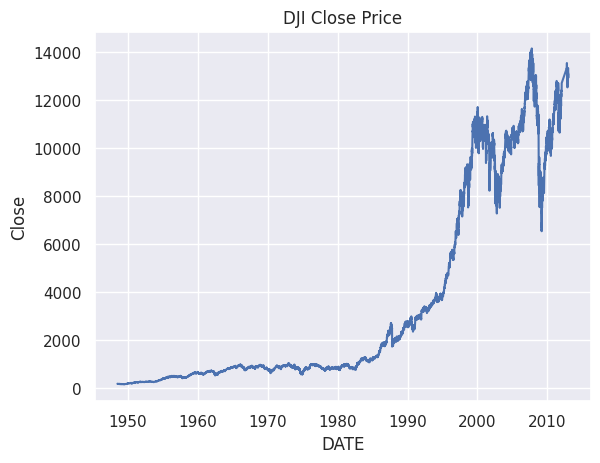

In [ ]:
#@title Construct the outcome variable
_ = sns.lineplot(data=df.Close).set_title('DJI Close Price')

If you squint hard enough, the closing price time series appears similar to an exponential series, with variance significantly higher towards the right of the plot than towards the left. In order to linearize an exponential series, we apply the natural logarithm:

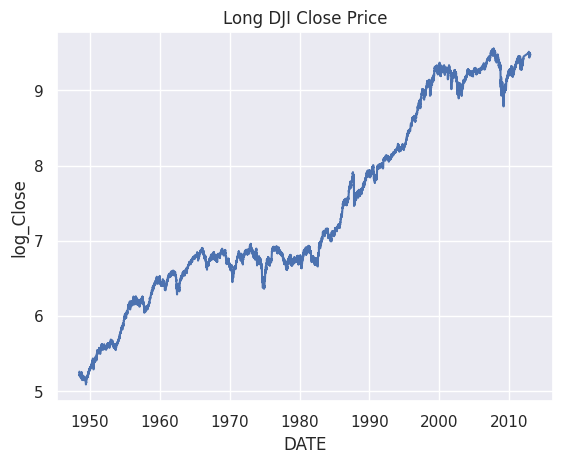

In [ ]:
df['log_Close'] = np.log(df.loc[:, 'Close'])
_ = sns.lineplot(data=df.log_Close).set_title('Long DJI Close Price')

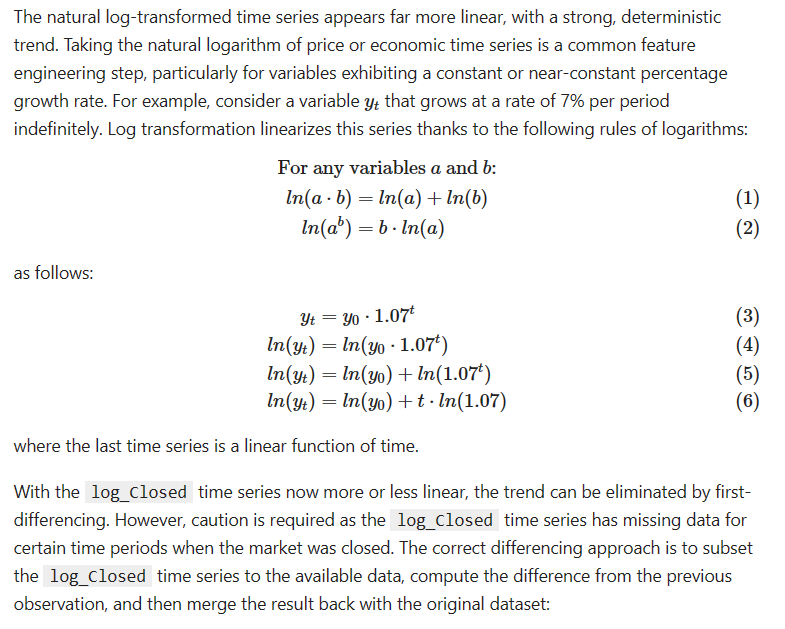

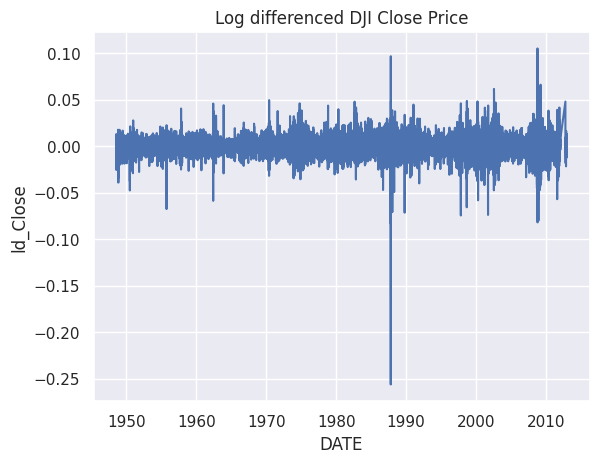

In [ ]:
log_Close = deepcopy(df.loc[:, 'log_Close'])
log_Close.dropna(inplace=True)
ld_Close = log_Close.diff()
df = df.merge(
    pd.DataFrame(ld_Close).rename({'log_Close':'ld_Close'},axis=1),
    how='left',
    left_index=True,
    right_index=True
)
_ = sns.lineplot(data=df.ld_Close).set_title('Log differenced DJI Close Price')

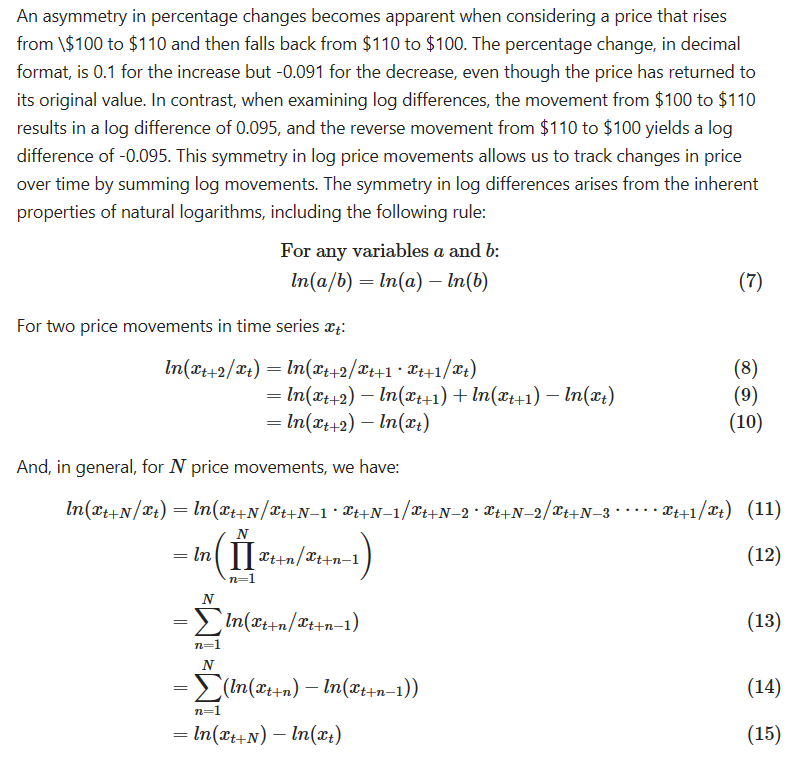



To assess the stationarity of the log-differenced DJI prices, Augmented Dickey-Fuller (ADF) and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests can be conducted. For each of these tests, the following prints the p-value of the test. The p-value of a test states the probability that the observed test result would occur through random chance alone, and is a useful in assessing whether to reject the null hypothesis in favor of the alternative.

In [ ]:
print('p-value of ADF test:')
print(adfuller(df.ld_Close.dropna())[1])
print('p-value of KPSS test:')
print(kpss(df.ld_Close.dropna())[1])

p-value of ADF test:
0.0
p-value of KPSS test:
0.1


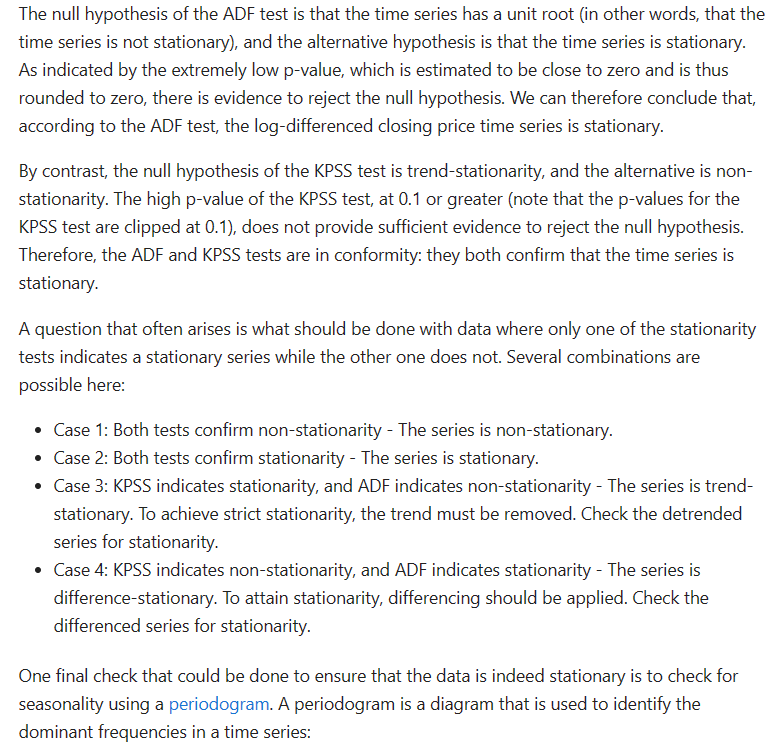

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

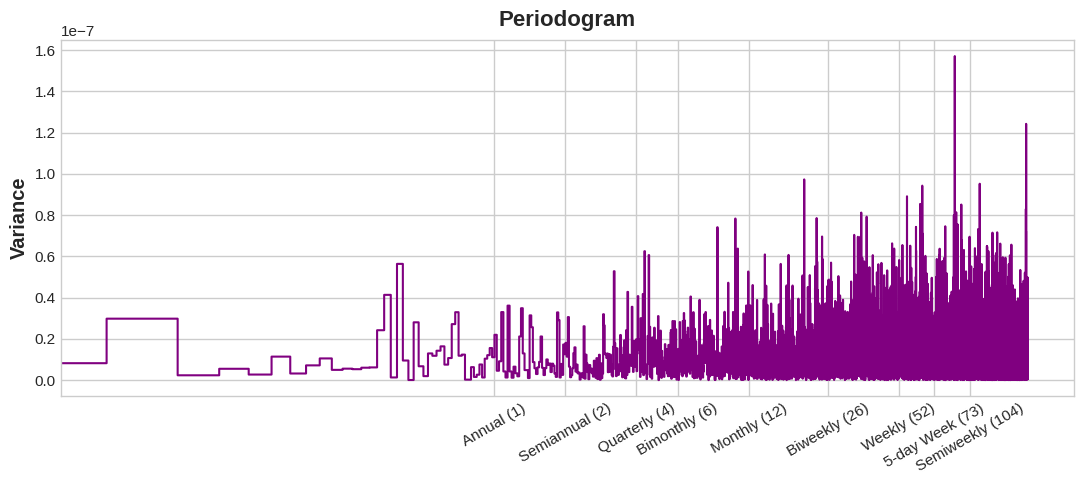

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D6H") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 73, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "5-day Week (73)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)


plot_periodogram(df.loc[:, 'ld_Close'].dropna())

For completeness, one could also look at the periodogram of the undifferenced series:

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

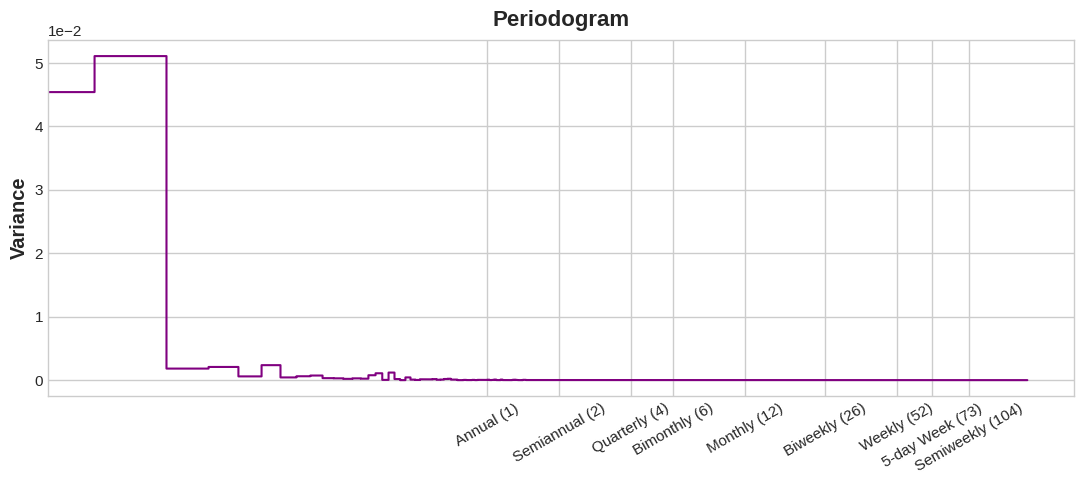

In [ ]:
plot_periodogram(df.loc[:, 'log_Close'].dropna())

The periodogram analysis reveals no significant peaks at frequencies where seasonality is typically expected. While there is a mild indication of seasonality at a 6-day cycle for the differenced series, it is not particularly prominent. For practical purposes, it can be assumed that the log returns of the DJI index are not strongly seasonal or cyclical. If there was a clear cyclical pattern, it would present an opportunity for investors to earn excess returns by following that cycle. However, such anomalies are quickly identified and replicated by other investors, leading to purchase and sale actions that eliminate the anomaly. Therefore, the DJI log returns are assumed to be devoid of seasonality and are considered stationary.

## Construct the features

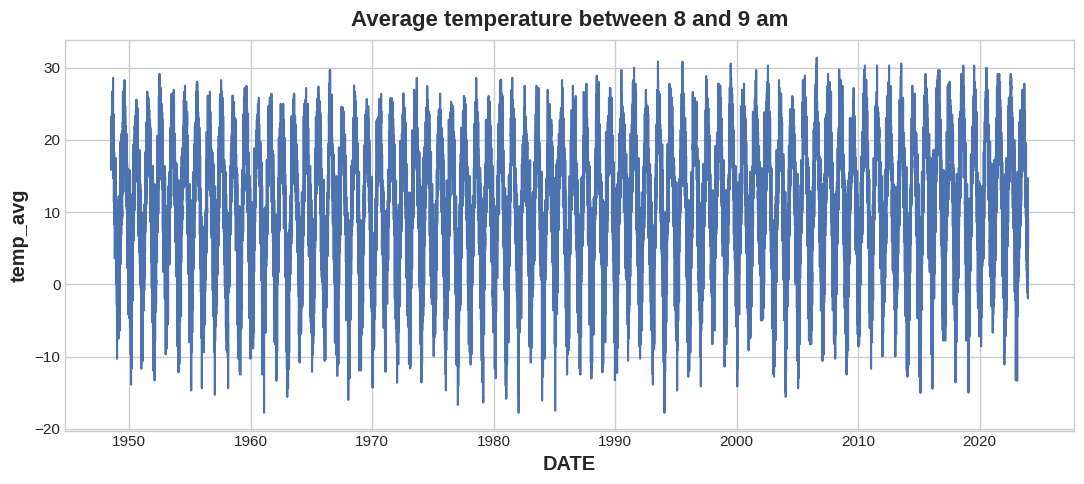

In [ ]:
#@title Make the average temperature time series stationary
# Consider the plot of average temperatures:
_ = sns.lineplot(data=df['temp_avg']).set_title('Average temperature between 8 and 9 am')

This time series exhibits a very strong seasonal component: temperatures vary in a predictable way by season. We can confirm the presence of seasonality by analyzing the periodogram:

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

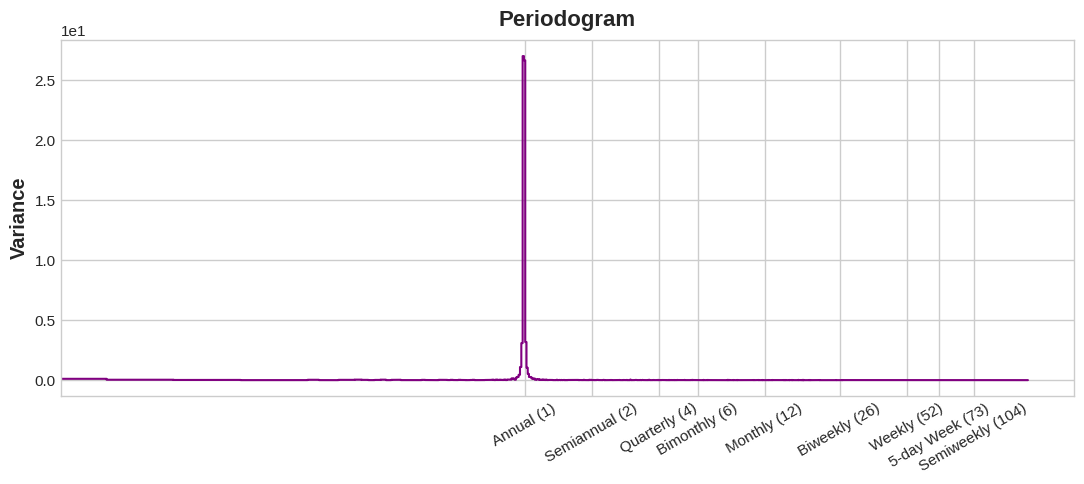

In [ ]:
plot_periodogram(df.loc[:, 'temp_avg'].dropna())

It is obvious that the time series exhibits strong seasonality at the annual frequency. The time series must be seasonally adjusted in order to produce a stationary series.

Several methods exist for seasonally adjusting a time series. Because we are interested in a prediction task, we will limit ourselves to methods that rely solely on past data and that can be readily applied to new data as it becomes available.

We will adopt a strategy of fitting a polynomial to the average temperatures for the initial years of the data and use that polynomial to estimate the seasonal effect moving forward. This approach offers some advantages over seasonal differencing, which relies on the difference between the current year's observation and the observation from the previous year. In particular, the polynomial fit is less influenced by unusually high or low readings from the previous year, as it considers a training window with data taken from multiple years, as well as from days that are not exactly 12 months before the current observation.

However, the drawback of using a polynomial fit is that a substantial number of years are required to generate the fit, and those years become unavailable for future analysis. In this case, I utilized 16 years, which provides a sufficiently large data sample for a robust fit, while also being a multiple of 4, which helps to account for leap years occurring every 4 years. The order of the polynomial fit could be 4 or 5, as these orders ought to be adequate to produce a curve resembling a sine wave. Feel free to experiment with the order in your own projects. In this analysis, I used a fourth-order polynomial:

In [ ]:
# Seasonally adjust average temp
y = df.loc[df.index < '1964-01-02', 'temp_avg']
X = [i % 365.25 for i in range (0, len(y.to_numpy()))]
X_full = [i % 365.25 for i in range(0, len(df.temp_avg.to_numpy()))]
degree = 4
coef = np.polyfit(X, y.to_numpy(), degree)
print('Coefficients: %s' % coef)
# create seasonal component
temp_sc_avg = list()
for i in range(len(X_full)):
  value = coef[-1]
  for d in range(degree):
    value += X_full[i]**(degree-d) * coef[d]
  temp_sc_avg.append(value)

df['temp_sc_avg'] = temp_sc_avg
df['temp_sa'] = df['temp_avg'] - df['temp_sc_avg']

Coefficients: [-2.27039916e-08  1.89119633e-05 -4.47566270e-03  2.22570025e-01
  1.91433822e+01]


Plot the pediogram of the seasonally adjusted temperature data:

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

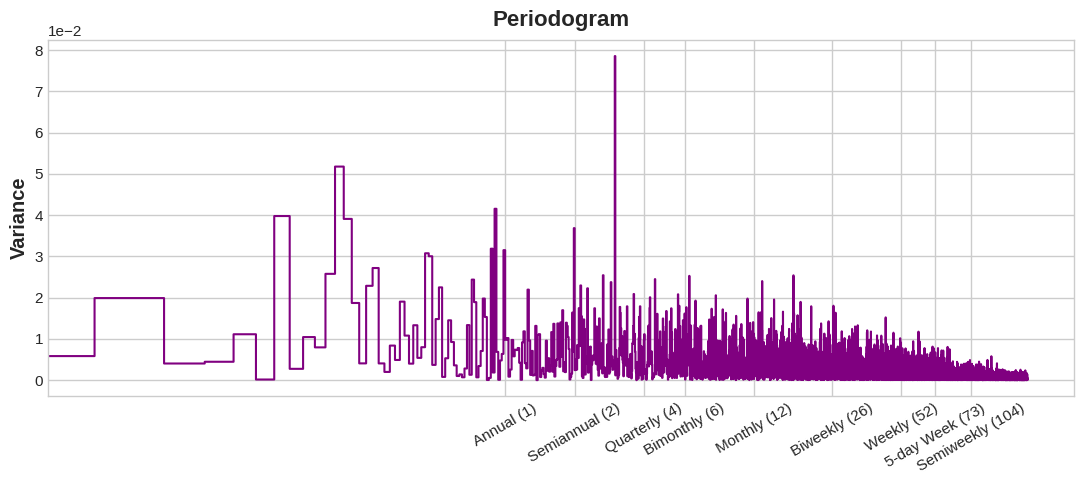

In [ ]:
plot_periodogram(df.loc[df.index >= '1964-01-02', 'temp_sa'].dropna())

The periodogram indicates that the seasonal adjustment successfully eliminated the seasonal component at the annual frequency.

Now, test the seasonally adjusted temperature data for stationarity:

In [ ]:
print('p-value of ADF test:')
print(adfuller(df.loc[df.index >= '1964-01-02', 'temp_sa'].dropna())[1])
print('p-value of KPSS test:')
print(kpss(df.loc[df.index >= '1964-01-02', 'temp_sa'].dropna())[1])

p-value of ADF test:
0.0
p-value of KPSS test:
0.01


According to the ADF test, the data exhibits stationarity. However, the KPSS test suggests non-stationarity. This discrepancy is surprising and suggests that temperatures in New York City follow a stochastic trend, meaning the temperature time series does not revert to its previous state after a shock. Notably, the stationarity tests did not indicate a deterministic trend in temperature (as would be the case if KPSS indicated stationarity but ADF did not). This implies that global warming is not a deterministic process but rather a result of various shocks leading to higher mean temperatures in locations such as New York City.

In order to make a time series with a stochastic trend stationary, we difference the series:

In [ ]:
df['temp_sa_d'] = df['temp_sa'].diff()
print('p-value of ADF test:')
print(adfuller(df.loc[df.index >= '1964-01-02', 'temp_sa_d'].dropna())[1])
print('p-value of KPSS test:')
print(kpss(df.loc[df.index >= '1964-01-02', 'temp_sa_d'].dropna())[1])

p-value of ADF test:
0.0
p-value of KPSS test:
0.1


Cloud cover periodogram:


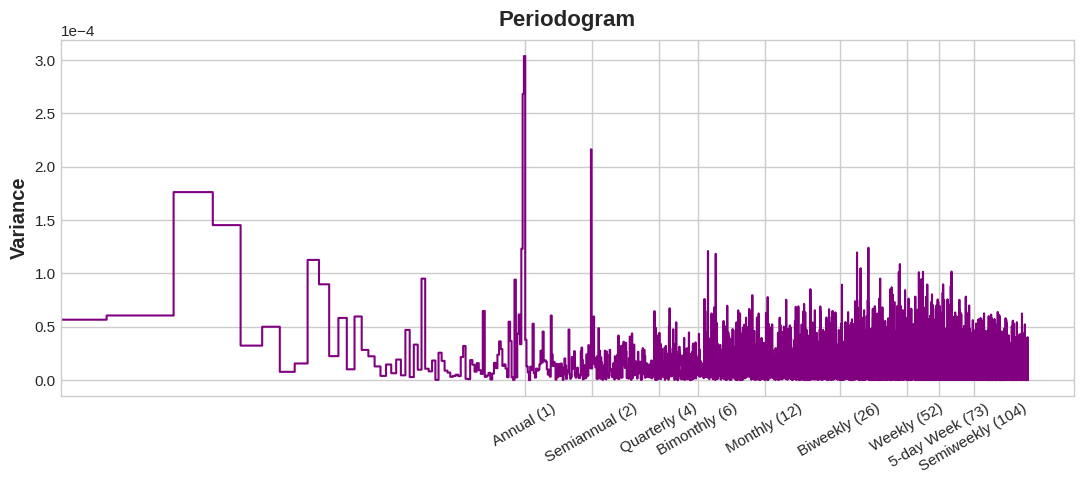

In [ ]:
#@title Make the average cloud cover time series
print('Cloud cover periodogram:')
plot_periodogram(df.loc[:,'cloud_cover_avg'].dropna())
plt.show()

Create the seasonal component to adjust cloud cover by filling in the missing code in the for loop below. Store the seasonal component in a variable called value.

In [ ]:
# Seasonally adjust average cloud_cover
y = df.loc[df.index < '1964-01-02', 'cloud_cover_avg']
X = [i % 365.25 for i in range (0, len(y.to_numpy()))]
X_full = [i % 365.25 for i in range(0, len(df.cloud_cover_avg.to_numpy()))]
degree = 4
coef = np.polyfit(X, y.to_numpy(), degree)
print('Coefficients: %s' % coef)
# create seasonal component
cloud_cover_sc_avg = list()
for i in range(len(X_full)):
  value = coef[-1]
  for d in range(degree):
    value += X_full[i]**(degree-d) * coef[d]
  cloud_cover_sc_avg.append(value)

df['cloud_cover_sc_avg'] = cloud_cover_sc_avg
df['cloud_cover_sa'] = df['cloud_cover_avg'] - df['cloud_cover_sc_avg']


Coefficients: [ 9.14705856e-11 -9.24871549e-08  2.91763216e-05 -2.91766022e-03
  5.51703112e-01]


Periodogram for seasonally adjusted cloud cover:


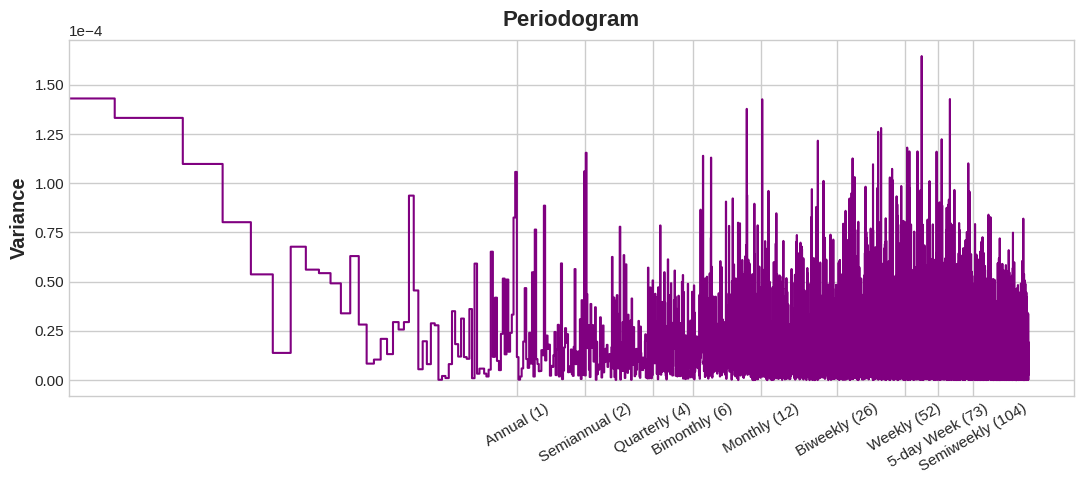

In [ ]:
print('Periodogram for seasonally adjusted cloud cover:')
plot_periodogram(df.loc[df.index >= '1964-01-01','cloud_cover_sa'].dropna())
plt.show()

In [ ]:
print('Stationarity tests for seasonally adjusted cloud cover')
print('p-value of ADF test:')
print(adfuller(df.loc[df.index >= '1964-01-02', 'cloud_cover_sa'].dropna())[1])
print('p-value of KPSS test:')
print(kpss(df.loc[df.index >= '1964-01-01', 'cloud_cover_sa'].dropna())[1])


Stationarity tests for seasonally adjusted cloud cover
p-value of ADF test:
0.0
p-value of KPSS test:
0.01


In [ ]:
# Take the first difference of cloud cover:
df['cloud_cover_sa_d'] = df['cloud_cover_sa'].diff()
print('Stationarity tests for difeerenced seasonally adjusted cloud cover')
print('p-value of ADF test:')
print(adfuller(df.loc[df.index >= '1964-01-02', 'cloud_cover_sa_d'].dropna())[1])
print('p-value of KPSS test:')
print(kpss(df.loc[df.index >= '1964-01-02', 'cloud_cover_sa_d'].dropna())[1])

Stationarity tests for difeerenced seasonally adjusted cloud cover
p-value of ADF test:
0.0
p-value of KPSS test:
0.1


The ADF and KPSS tests above indicate that differencing the seasonally adjusted cloud cover time series was sufficient to obtain a stationary series.

As a final step, we should now remove the first 16 years from the dataset because we used those years to fit the polynomials for seasonal adjustment:

In [ ]:
df = df.loc[df.index >= '1964-01-02']

# Time series train-test split and cross-validation

With non-time series data, as long as the data is not grouped, the train-test split can be made by randomly assigning a certain fraction of observations to the training set, with the rest of the observations assigned to the test set.

With time series data, this process is more complex. Because the observations occur in a particular order, typically the earlier observations are assigned to the training set, and latter observations are assigned to the test set. It is important to leave a gap between the two sets of at least the number of lagged variables included in the model so as to avoid data leakage between the train and test sets.

Cross-validation proceeds in a similar fashion. In the first fold, a pre-defined fraction of the earliest observations, say the first 18% of observations, are used to train the model; the next 1% of observations are left as a gap; and that model is then used to predict the next 18% of observations. Then, for the next fold, the model is trained on 36% of the earliest data, the next 1% is left as a gap, and the test set comprises the next 18%, and so on. Run the following code to generate a plot that illustrates this concept:


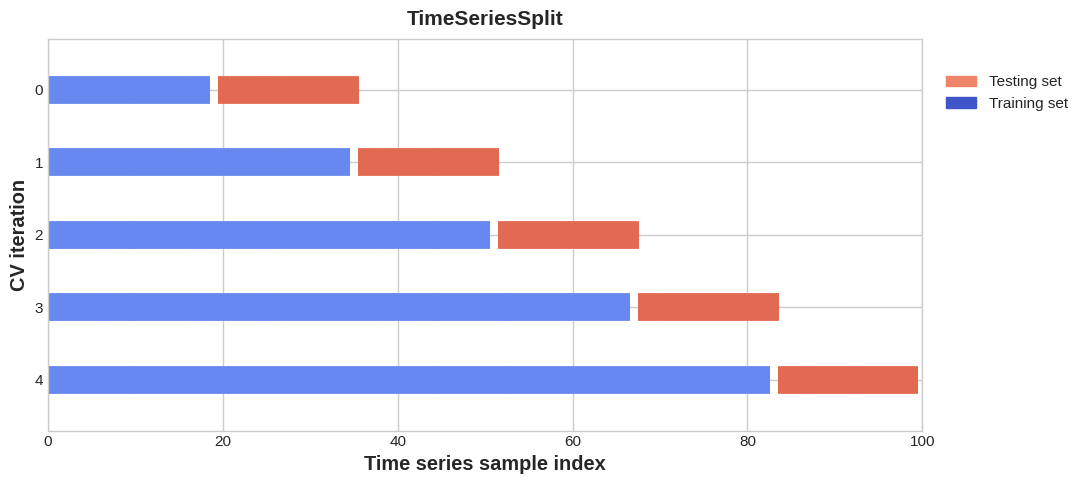

In [ ]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=20):
    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            s=50,
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )
    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Time series sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 0.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


fig, ax = plt.subplots()
cv = TimeSeriesSplit(5, gap=1)
rng = np.random.RandomState(2024)
X = rng.randn(100, 10)
percentiles_classes = [0.33, 0.33, 0.34]
y = np.hstack(
    [[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)]
)
group_prior = rng.dirichlet([2] * 10)
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))
plot_cv_indices(cv, X, y, groups, ax, 5)
ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
)
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=0.7)

In [ ]:
#@title Define the folds for cross-validation
# Time series split
tscv = TimeSeriesSplit(n_splits=10, gap=15)
splits = list(tscv.split(df.ld_Close.dropna()))

# Construct and evaluate the prediction models using cross-validation

It is finally time to build some prediction models, and to assess their performance using cross-validation!

To evaluate the models' performance, we will employ the mean absolute error (MAE) metric. This choice is appropriate as the MAE provides insights into how much our mean prediction deviates from the true log return. Given that log returns have a natural interpretation—particularly for small percentage changes where the log return is approximately equivalent in magnitude to the percentage change—the MAE is a suitable metric. For instance, if the MAE is 0.005, it implies that, on average, our prediction deviates by roughly half a percentage point from the true daily percentage return.

# Linear regression

## Predict using the mean from the training period

The most basic model that could be conceived is one that predicts the daily log return using the mean from the training period. Such a prediction can be made by regressing log returns on a vector of ones. The following trains 10 such models, one for every fold in our cross-validation. Each of these models is used to make one-step-ahead predictions for the observations in their fold's test set. A mean absolute error is then calculated using the predictions from all 10 folds:


In [ ]:
trues_raw = []
preds_raw = []
results_ols_m = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.OLS(
        df.ld_Close.dropna().to_numpy()[splits[i][0]],
        sm.add_constant(
            df.ld_Close.dropna().to_numpy()[splits[i][0]]
        )[:, [0]]
    )
    res = mod.fit(disp=False)
    pred = res.predict(
        sm.add_constant(
            df.ld_Close.dropna().to_numpy()[splits[i][1]]
        )[:, [0]]
    )
    preds_raw.append(pred)
    trues_raw.append(df['ld_Close'].dropna().to_numpy()[splits[i][1]])
    results_ols_m.append(res)

trues = np.concatenate(trues_raw)
preds = np.concatenate(preds_raw)
reg_mean_absolute_error = mean_absolute_error(trues, preds)

linreg_mean_mae = []
for i in range(len(trues_raw)):
    linreg_mean_mae.append(mean_absolute_error(trues_raw[i], preds_raw[i]))

print('MAE, regress on constant alone: ' + str(reg_mean_absolute_error))
del mod, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

MAE, regress on constant alone: 0.007391160254661744


The results show that across all predictions made using the 10 folds, the mean absolute error (MAE) was 0.007391. This corresponds to a roughly 0.7391 percentage point difference between the true daily return and the predicted daily return, on average.

### Predict using a linear regression with temperature and cloud cover as inputs

Perform the following exercise to predict daily log returns by regressing log returns on a constant, average temperature, and cloud cover in NYC between 8 and 9 am:


In [ ]:
trues_raw = []
preds_raw = []
results_ols_tcc = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.OLS(
        df.ld_Close.dropna().to_numpy()[splits[i][0]],
        sm.add_constant(
            df[['ld_Close', 'temp_sa_d', 'cloud_cover_sa_d']].dropna().loc[
                :, ['temp_sa_d', 'cloud_cover_sa_d']
            ].to_numpy()[splits[i][0]]
        )
    )
    res = mod.fit(disp=False)
    pred = res.predict(
        sm.add_constant(
            df[['ld_Close', 'temp_sa_d', 'cloud_cover_sa_d']].dropna().loc[
                :, ['temp_sa_d', 'cloud_cover_sa_d']
            ].to_numpy()[splits[i][1]]
        )
    )
    preds_raw.append(pred)
    trues_raw.append(df['ld_Close'].dropna().to_numpy()[splits[i][1]])
    results_ols_tcc.append(res)

trues = np.concatenate(trues_raw)
preds = np.concatenate(preds_raw)
reg_mean_absolute_error = mean_absolute_error(trues, preds)

linreg_weather_mae = []
for i in range(len(trues_raw)):
    linreg_weather_mae.append(mean_absolute_error(trues_raw[i], preds_raw[i]))

print('MAE, regress on weather variables: ' + str(reg_mean_absolute_error))
del mod, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

MAE, regress on weather variables: 0.0073890777718353074


As observed above, a marginal improvement in prediction is achieved by incorporating the weather variables.

As part of the diagnostic process, examining the p-values associated with the coefficients in the linear regression could provide valuable insights. To carry out this analysis, we can focus on the regression from the last fold, as it contains the most training data:

In [ ]:
results_ols_tcc[-1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.566
Date:                Mon, 26 Feb 2024   Prob (F-statistic):             0.0283
Time:                        05:06:09   Log-Likelihood:                 35483.
No. Observations:               11023   AIC:                        -7.096e+04
Df Residuals:                   11020   BIC:                        -7.094e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   9.22e-05      2.868      0.004    8.37e-05       0.000
x1          1.218e-05   2.57e-05      0.474      0.636   -3.82e-05    6.26e-05
x2            -0.0005      0.000     -2.625      0.009      -0.001      -0.000
==============================================================================
Omnibus:                     6420.919   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1139067.254
Skew:                          -1.738   Prob(JB):                         0.00
Kurtosis:                      52.679   Cond. No.                         7.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficient on x1, representing the seasonally adjusted and differenced average temperature, has a p-value of 0.636. By contrast, the second coefficient, the one on seasonally adjusted and differenced average cloud cover, has a p-value of 0.009. This suggests that cloud cover is linearly related to log returns for the DJI index at the 0.01 significance level.

In [ ]:
trues_raw = []
preds_raw = []
results_ols_cc = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.OLS(
        df.ld_Close.dropna().to_numpy()[splits[i][0]],
        sm.add_constant(
            df[['ld_Close', 'cloud_cover_sa_d']].dropna().loc[
                :, ['cloud_cover_sa_d']
            ].to_numpy()[splits[i][0]]
        )
    )
    res = mod.fit(disp=False)
    pred = res.predict(
        sm.add_constant(
            df[['ld_Close', 'cloud_cover_sa_d']].dropna().loc[
                :, ['cloud_cover_sa_d']
            ].to_numpy()[splits[i][1]]
        )
    )
    preds_raw.append(pred)
    trues_raw.append(df['ld_Close'].dropna().to_numpy()[splits[i][1]])
    results_ols_cc.append(res)

trues = np.concatenate(trues_raw)
preds = np.concatenate(preds_raw)
reg_mean_absolute_error = mean_absolute_error(trues, preds)

linreg_cc_mae = []
for i in range(len(trues_raw)):
    linreg_cc_mae.append(mean_absolute_error(trues_raw[i], preds_raw[i]))

print('MAE, regress on weather variables: ' + str(reg_mean_absolute_error))
del mod, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

MAE, regress on weather variables: 0.0073883918328644434


In [ ]:
results_ols_cc[-1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.908
Date:                Mon, 26 Feb 2024   Prob (F-statistic):            0.00859
Time:                        05:38:42   Log-Likelihood:                 35483.
No. Observations:               11023   AIC:                        -7.096e+04
Df Residuals:                   11021   BIC:                        -7.095e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   9.22e-05      2.870      0.004    8.39e-05       0.000
x1            -0.0005      0.000     -2.628      0.009      -0.001      -0.000
==============================================================================
Omnibus:                     6420.919   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1139119.829
Skew:                          -1.738   Prob(JB):                         0.00
Kurtosis:                      52.680   Cond. No.                         1.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Beyond this, we can make a more profound assertion. While correlation does not necessarily imply causation, and determining the direction of causation can be challenging, in this instance, we can rely on both reason and our domain knowledge of weather and stock markets in order to make a causal argument. Given that it is more plausible for weather conditions to drive stock market changes than the other way around (imagining a world where stock movements dictate the pre-open cloudiness would be highly unusual), we can claim that cloud cover in New York City causes some of the variation in the log returns of the DJI index. This is a significant and meaningful finding.

However, despite this impactful discovery, the regression results offer a sobering insight: the R-squared value, representing the proportion of the variation in log returns predicted by cloud cover in New York City, is exceedingly small, equal to 0.001 or less. The following code obtains the exact value of R-squared, or more precisely, the adjusted R-squared, a corrected version of R-squared that accounts for the number of predictors:

In [ ]:
results_ols_cc[-1].rsquared_adj

0.0005356987940902114

There you have it. Cloud cover in New York City explains just 0.054% of the variation in the log returns of the Dow Jones Industrial Average. While statistically significant, the economic significance of this finding is limited due to cloud cover's minor impact on the DJI.

On the other hand, would it have been reasonable to expect a larger effect from just one, easily observable variable? Certainly, for an exceedingly intricate system such as the stock market, where millions of individuals make decisions in their own best interests based on an immense amount of information, the surprising aspect lies in the fact that an easily observable variable like cloud cover has any statistical effect at all. It is just one of many variables moving the market, and its significance in moving that market is accordingly rather small.

As a final sanity check one should consider the sign on the coefficient of the variable of interest. In this particular case, the coefficient is negative. A negative coefficient implies that greater cloud cover is associated with lower DJI log returns. This is exactly what one would expect: an easy hypothesis, not tested in this guided project, is that an unseasonably large amount of cloud cover causes more gloom amongst traders and investors, causing them to sell more and buy less than they otherwise would on a nice day.

Even though cloud cover is identified as a causal factor for DJI log returns, the question remains whether or not cloud cover could be used to improve DJI log return predictions. If forecasts are made using linear regression, the above cross-validation suggests that the inclusion of cloud cover improves predictions ever so slightly over baseline predictions made by mean returns. It seems that, at least within the realm of linear regression, incorporating cloud cover could lead to slightly improved predictions.

## The ARMAX model

The aforementioned observation is indeed noteworthy, but its impact on our prediction accuracy, as measured by MAE, is not substantial. Let's investigate whether the inclusion of cloud cover proves beneficial in enhancing the prediction of the DJI within a more intricate model than a simple linear regression. In the upcoming analysis, we will construct an <a href="https://en.wikipedia.org/wiki/Autoregressive_moving-average_model#Autoregressive%E2%80%93moving-average_model_with_exogenous_inputs_model_(ARMAX_model)">ARMAX</a> model.

### An introduction to ARMAX models
ARMAX is a subset of the renowned <a href="https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">SARIMAX</a> model, which stands for Seasonal AutoRegressive Integrated Moving Average with eXogenous variables. Through SARIMAX, ARMAX is directly related to the more known <a href="https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average">ARIMA</a> model: the ARMAX model is a subset of the SARIMAX model that does not use the seasonal or integrated components, while the ARIMA model is a subset of SARIMAX that does not use the seasonal and exogenous components. In order to understand the ARMAX model, it is best to start with an understanding of an autoregressive model of order $p$, the AR($p$) model, which predicts the current value of an outcome variable using $p$ lagged observations:

$$
\begin{align}
y_t &= \theta_0 + \sum_{i=1}^p \theta_i y_{t-i} + \epsilon_t
\end{align}
$$

where $\theta_0$ is a constant, $p$ is the number of lags, $\epsilon_t$ is the noise at time $t$, and $\theta_i$ is the coefficient on lag $i$.

This equation can be made concise using the lag operatior, $L$:

$$
\begin{align}
L^ny_t &= y_{t-n}
\end{align}
$$

If we denote $\Theta(L)^p$ to be a $p$ order polynomial function of the lag operator $L$, then the autoregressive model can be written as

$$
\begin{align}
y_t &= \Theta(L)^p y_{t} + \epsilon_t
\end{align}
$$

By contrast, a moving average (MA) model of order $q$ predicts the outcome variable using lagged prediction errors $\epsilon$:

$$
\begin{align}
y_t &= \Phi(L)^q \epsilon_{t} + \epsilon_t
\end{align}
$$

Putting these models together yields the ARMA($p$,$q$) model:

$$
\begin{align}
y_t &= \Theta(L)^p y_{t} + \Phi(L)^q \epsilon_{t} + \epsilon_t
\end{align}
$$

In order to convert to an ARMAX model, the $n$ exogenous variables enter the model additively:

$$
\begin{align}
y_t &= \Theta(L)^p y_{t} + \Phi(L)^q \epsilon_{t} + \sum_{i=1}^n \beta_i x^i_t +  \epsilon_t
\end{align}
$$

Thus, an ARMAX model differs from linear regression by adding lagged terms for the outcome variable and moving average terms that depend on the prediction error. Because of the dependence on the previous prediction error, this model cannot be solved using <a href="https://en.wikipedia.org/wiki/Ordinary_least_squares">ordinary least squares (OLS)</a>; instead, the <a href="https://en.wikipedia.org/wiki/Maximum_likelihood_estimation">maximum likelihood estimation (MLE)</a> method is typically used.

### Find optimal lag orders

Before continuing to construct an ARMA or ARMAX model, we must find optimal autogregressive and moving average orders.


Ideally, for a prediction task, one would employ cross-validation, testing various combinations of autoregressive (AR) and moving average (MA) lag orders and comparing the prediction accuracy using metrics like Mean Absolute Error (MAE). However, due to the time-consuming nature of fitting SARIMAX models and their derivatives using Maximum Likelihood Estimation (MLE), we'll opt for a quicker approach. We'll use the classical method of selecting lag orders, leveraging the <a href="https://en.wikipedia.org/wiki/Akaike_information_criterion">Akaike Information Criterion (AIC)</a> and the <a href="https://en.wikipedia.org/wiki/Bayesian_information_criterion">Bayesian Information Criterion (BIC)</a>. These criteria serve as estimators for prediction error and the relative quality of statistical models for a given dataset. The goal is to identify lag orders that minimize both AIC and BIC. If the lag orders minimizing AIC and BIC differ, the researcher can choose either order based on how parsimonious the model should be, with BIC typically favoring more parsimonious models than AIC.

As we're about to observe, this approach of selecting lag orders may not be optimal for a prediction task, despite the widespread use of information criteria for lag selection in ARIMA-type models. To expedite the process, we will execute the lag order selection code below for a limited range of autoregressive and moving average orders. Additionally, we will apply the code solely to the last fold, as it encompasses the largest volume of training data.


In [ ]:
# ARMA lag order selection using just one fols.
min_ar_ma = [2,6] # Minimum (p,q)
max_ar_ma = [4,8] # Maximum (p,q)

# Note : according to the AIC cirteria, identical AR and MA lags are found if
# the maximum and minimum bounds are:
#min_ar_ma = [1,1] # Minimum (p, q)
#max_ar_ma = [8,8] # Maximum (p, q)

aic_pd = pd.DataFrame(
    np.empty((max_ar_ma[0]+1-min_ar_ma[0],
              max_ar_ma[1]+1-min_ar_ma[1]),
             dtype=float),
    index=list(range(max_ar_ma[0]+1-min_ar_ma[0])),
    columns=list(range(max_ar_ma[1]+1-min_ar_ma[1]))
)

bic_pd = pd.DataFrame(
    np.empty((max_ar_ma[0]+1-min_ar_ma[0],
              max_ar_ma[1]+1-min_ar_ma[1]),
             dtype=float),
    index=list(range(max_ar_ma[0]+1-min_ar_ma[0])),
    columns=list(range(max_ar_ma[1]+1-min_ar_ma[1]))
)

for p in tqdm.tqdm_notebook(range(
    min_ar_ma[0], max_ar_ma[0]+1), position =1, desc='p'):
  for q in range(min_ar_ma[1], max_ar_ma[1]+1):
    if p== 0 and q == 0:
      aic_pd.loc[p,q] = np.nan
      bic_pd.loc[p,q] = np.nan
      continue
    # Estimate the model with no missing datapoints
    mod = sm.tsa.statespace.SARIMAX(
        df['ld_Close'].dropna().iloc[splits[-1][0]],
        order=(p, 0, q),
        trend='c',
        enforce_inertibility=False
    )
    try:
      res = mod.fit(disp=False)
      aic_pd.loc[p, q] = res.aic
      bic_pd.loc[p, q] = res.bic
    except:
      aic_pd.loc[p, q] = np.nan
      bic_pd.loc[p, q] = np.nan

print('AIC: optimal AR order: ' +
      str(aic_pd.min(axis=1).idxmin()) +
      ', optimal MA order: ' +
      str(aic_pd.min().idxmin()))
print('BIC: optimal AR order: ' +
      str(bic_pd.min(axis=1).idxmin()) +
      ', optimal MA order: ' +
      str(bic_pd.min().idxmin()))



p:   0%|          | 0/3 [00:00<?, ?it/s]

AIC: optimal AR order: 2, optimal MA order: 7
BIC: optimal AR order: 2, optimal MA order: 7


In this scenario, both the AIC and BIC criteria agree on the optimal number of lags to be selected. It's important to note that even if the order bounds for  𝑝
  and  𝑞
  were expanded to a range between 1 and 8, as opposed to the more restrictive bounds chosen for efficiency purposes, the AIC criterion would have still recommended the same lag orders. Consequently, the proposed 2 autoregressive (AR) orders and 7 moving average (MA) orders are considered reasonable parameter values.

In [ ]:
#@title Predict using the ARMA model
trues = []
preds = []
results = []
for i in tqdm.tqdm_notebook(range(len(splits))):
  mod = sm.tsa.statespace.SARIMAX(
      df['ld_Close'].dropna().to_numpy()[splits[i][0]],
      order=(2, 0, 7),
      trend='c',
      enforce_invertibility=False
  )
  res = mod.fit(disp=False)
  pred = res.predict(
      data=df['ld_Close'].dropna().to_numpy(),
      start=splits[i][1][0],
      end=splits[i][1][-1]
  )
  preds.append(pred)
  trues.append(df['ld_Close'].dropna().to_numpy()[splits[i][1]])
  results.append(res)

trues = np.concatenate(trues)
preds = np.concatenate(preds)

arma_absolute_error = mean_absolute_error(trues, preds)
print('ARMA(2,7) MAE: ' +str(arma_absolute_error))

  0%|          | 0/10 [00:00<?, ?it/s]

ARMA(2,7) MAE: 0.007391203331046744


In this instance, we observe a surprising outcome: the ARMA(2,7) model performs worse than a linear regression model with a constant!

This result emphasizes the idea that employing a more complex model for a challenging prediction task doesn't guarantee improved predictions. Specifically, in this case, it's clear that adding 2 autoregressive lags and 7 moving average lags for the error term didn't enhance the model's predictive capabilities. While experimenting with different lag orders might produce varying results, the crucial lesson is that simply introducing more variables or opting for a more intricate model doesn't automatically result in superior performance

In [ ]:
#@title Predict using the ARMAX model with temperature and clod cover as exogenous inputs
trues = []
preds = []
results = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.tsa.statespace.SARIMAX(
        df['ld_Close'].dropna().to_numpy()[splits[i][0]],
        order=(2, 0, 7),
        trend='c',
        enforce_invertibility=False,
        exog=df[['temp_sa_d', 'cloud_cover_sa_d', 'ld_Close']].dropna().loc[
            :, ['temp_sa_d', 'cloud_cover_sa_d']
        ].to_numpy()[splits[i][0]]
    )
    res = mod.fit(disp=False)
    pred = res.predict(
        data=df['ld_Close'].dropna().to_numpy(),
        start=splits[i][1][0],
        end=splits[i][1][-1],
        exog=df[['cloud_cover_sa_d', 'temp_sa_d', 'ld_Close']].dropna().loc[
            :, ['temp_sa_d', 'cloud_cover_sa_d']
        ].to_numpy()[splits[i][1][0]-16:splits[i][1][-1]]
    )
    preds.append(pred)
    trues.append(df['ld_Close'].dropna().to_numpy()[splits[i][1]])
    results.append(res)

trues = np.concatenate(trues)
preds = np.concatenate(preds)

armax_weather_absolute_error = mean_absolute_error(trues, preds)
print('ARMAX(2,7) with weather variables MAE: ' +
      str(armax_weather_absolute_error))

  0%|          | 0/10 [00:00<?, ?it/s]

ARMAX(2,7) with weather variables MAE: 0.007393388004059298


In [ ]:
results[-1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11023
Model:               SARIMAX(2, 0, 7)   Log Likelihood               35514.792
Date:                Mon, 26 Feb 2024   AIC                         -71003.584
Time:                        08:48:10   BIC                         -70908.583
Sample:                             0   HQIC                        -70971.582
                              - 11023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.395      0.163   -9.54e-05       0.001
x1          1.305e-05    2.6e-05      0.501      0.616    -3.8e-05    6.41e-05
x2            -0.0005      0.000     -2.664      0.008      -0.001      -0.000
ar.L1         -0.3685      0.400     -0.921      0.357      -1.152       0.415
ar.L2          0.4558      0.317      1.437      0.151      -0.166       1.077
ma.L1          0.4323      0.400      1.081      0.279      -0.351       1.216
ma.L2         -0.4656      0.318     -1.464      0.143      -1.089       0.158
ma.L3         -0.0495      0.024     -2.024      0.043      -0.097      -0.002
ma.L4         -0.0007      0.014     -0.050      0.960      -0.027       0.026
ma.L5          0.0017      0.009      0.198      0.843      -0.015       0.019
ma.L6         -0.0068      0.008     -0.859      0.390      -0.022       0.009
ma.L7         -0.0162      0.007     -2.358      0.018      -0.030      -0.003
sigma2      9.298e-05   3.53e-07    263.176      0.000    9.23e-05    9.37e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           1098183.66
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Once more, we note that the p-value linked with the cloud cover coefficient is below 0.01, signifying statistical significance. Conversely, the p-value for temperature is high, surpassing 0.1. Furthermore, the cloud cover coefficient is negative and comparable in magnitude to the one derived from linear regression. These results confirm the linear association between cloud cover and log returns, a connection that persists even in the presence of autoregressive and moving average terms. However, any potential enhancement in prediction performance by incorporating weather variables is overshadowed by the model misspecification.

In [ ]:
trues = []
preds = []
results = []
for i in tqdm.tqdm_notebook(range(len(splits))):
    mod = sm.tsa.statespace.SARIMAX(
        df[['cloud_cover_sa_d',
            'ld_Close']].dropna().ld_Close.to_numpy()[splits[i][0]],
        order=(2,0,7),
        trend='c',
        enforce_invertibility=False,
        exog=df[['cloud_cover_sa_d', 'ld_Close']].dropna().loc[
            :, ['cloud_cover_sa_d']
        ].to_numpy()[splits[i][0]]
    )
    res = mod.fit(disp=False)
    pred = res.predict(
        data=df[['cloud_cover_sa_d', 'ld_Close']].dropna().ld_Close.to_numpy(),
        start=splits[i][1][0], end=splits[i][1][-1],
        exog=df[['cloud_cover_sa_d', 'ld_Close']].dropna().loc[
            :, ['cloud_cover_sa_d']
        ].to_numpy()[splits[i][1][0]-16:splits[i][1][-1]]
    )
    preds.append(pred)
    trues.append(
        df[['cloud_cover_sa_d', 'ld_Close']].dropna().ld_Close.to_numpy()[
            splits[i][1]
        ]
    )
    results.append(res)

trues = np.concatenate(trues)
preds = np.concatenate(preds)

armax_cc_absolute_error = mean_absolute_error(trues, preds)
print('ARMAX(2,7) with weather variables MAE: ' +
      str(armax_cc_absolute_error))
del mod, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

ARMAX(2,7) with weather variables MAE: 0.007392630045196354


In [ ]:
results[-1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11023
Model:               SARIMAX(2, 0, 7)   Log Likelihood               35516.947
Date:                Mon, 26 Feb 2024   AIC                         -71009.894
Time:                        09:11:15   BIC                         -70922.202
Sample:                             0   HQIC                        -70980.354
                              - 11023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.488      0.137    -7.5e-05       0.001
x1            -0.0004      0.000     -2.606      0.009      -0.001      -0.000
ar.L1         -0.3695      0.248     -1.492      0.136      -0.855       0.116
ar.L2          0.4575      0.229      1.995      0.046       0.008       0.907
ma.L1          0.4319      0.247      1.747      0.081      -0.053       0.916
ma.L2         -0.4653      0.243     -1.916      0.055      -0.941       0.011
ma.L3         -0.0514      0.009     -5.583      0.000      -0.069      -0.033
ma.L4          0.0012      0.013      0.099      0.921      -0.023       0.026
ma.L5         -0.0003      0.008     -0.043      0.966      -0.016       0.016
ma.L6         -0.0043      0.008     -0.564      0.573      -0.019       0.011
ma.L7         -0.0189      0.006     -2.951      0.003      -0.031      -0.006
sigma2      9.297e-05   3.55e-07    261.613      0.000    9.23e-05    9.37e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           1116500.26
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        52.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


Once again, the p-value associated with the cloud cover coefficient stands at a very low 0.009, aligning with our expectations, and the coefficient itself carries a negative sign.

This analysis of the ARMAX model yields two crucial lessons. Firstly, in any prediction project, careful consideration of feature selection and hyperparameter tuning is essential, and irrelevant features should be eliminated if identified. Secondly, opting for a more complex model doesn't automatically translate to superior predictions. Simple models, like linear regression, often excel when faced with challenging prediction tasks where the association between features and the outcome variable is not particularly strong.

While it's conceivable that an ARMAX-type model might perform better with the correct number of AR and MA lags, the current analysis doesn't strongly advocate for choosing an ARMAX model over the simpler linear regression model. The evidence gathered so far suggests that substantial improvements beyond the predictions made by linear regression are unlikely. Nonetheless, from a statistical standpoint, the ARMAX model summaries support the conclusion that cloud cover maintains a linear association with log returns, even in the presence of autoregressive and moving average terms.


## Random forest

In this section, we will fit an entirely different type of model to the data. Instead of relying on classical methods, we will now fit a <a href="https://en.wikipedia.org/wiki/Random_forest">random forest</a> model, a model that relies on <a href="https://en.wikipedia.org/wiki/Decision_tree_learning">decision trees</a>. In essence, decision trees resemble flow charts and split the data using cutoffs that maximize the separation of the data. A model based on decision trees may work particularly well on problems where certain cutoffs are of particular interest. For instance, if cloud cover being equal to or greater than 7/8 was associated with lower log returns, presumably because that is the threshold at which most traders begin to feel gloomy, then an algorithm that relies on decision trees should be able to pick that up with ease.

A common misconception about tree-based algorithms is that they cannot be used for time series analysis. This misunderstanding arises from the fact that tree-based algorithms are not proficient at extrapolation. For example, if you have an increasing series, such as the US GDP, that you aim to predict, tree-based models would only be capable of predicting the highest value encountered in training. Since time series train-test splits typically allocate later (larger) values to the test set, the decision tree-based model performs poorly as it cannot predict these future values effectively&mdash;it cannot make predictions beyond the range of what the model saw during training.

Furthermore, because tree-based models rely on making cutoffs, it is crucial that the features fed into these models are not trending. For instance, including US GDP as a feature in any tree-based model wouldn't make much sense: the cutoffs the trees would learn on previous GDP values would not hold much significance in testing, where GDP values are in a different range.

Consequently, decision-tree-based models can be used for time series analysis, provided that the features and the outcome variable are consistently within the same range throughout the entire dataset. While stationarity is a sufficient condition, it is not strictly necessary for tree-based algorithms. Instead, what is crucial is that the data is bounded, and a significant portion of the testing data is not outside the bounds of the data seen in training.

For our analysis, utilizing log-differenced DJI index prices as the outcome variables and seasonally adjusted and differenced cloud cover and temperature features is suitable, given their stationarity. Additionally, incorporating lags of the outcome variable as features is considered. While the optimal number of lags and other hyperparameter values could be determined through cross-validation, for simplicity, we will use 2 lags in this case. Furthermore, to expedite training time, we will set the max depth to just 2, though it is standard practice in real-world scenarios to find the optimal max depth through cross-validation.


In [ ]:
trues_rf = []
preds_rf = []
X_orig = df[['ld_Close']].dropna()
features = []
for i in range(1,3):
    features.append(
        df[['ld_Close']].dropna().shift(i).rename(
            {'ld_Close': 'ld_Close_'+str(i)}, axis=1
        )
    )
X = pd.concat(features + [X_orig], axis=1)
y = deepcopy(X_orig[['ld_Close']])
X.drop('ld_Close',axis=1,inplace=True)
for i in tqdm.tqdm_notebook(range(len(splits))):
    regr = RandomForestRegressor(criterion="friedman_mse",
                                 n_estimators=10,
                                 max_depth=2,
                                 random_state=2024)
    train_idx = splits[i][0][2:]
    res = regr.fit(X.iloc[train_idx],y.iloc[train_idx])
    pred = regr.predict(X.iloc[splits[i][1]])
    preds_rf.append(pred)
    trues_rf.append(
        df[['ld_Close']].dropna().ld_Close.to_numpy()[splits[i][1]]
    )

trues_rf = np.concatenate(trues_rf)
preds_rf = np.concatenate(preds_rf)

print(str(mean_absolute_error(trues_rf, preds_rf)))

rf_lags_absolute_error = mean_absolute_error(trues_rf, preds_rf)
print('Random forest with lagged prices MAE: ' +
      str(rf_lags_absolute_error))
del regr, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

0.007419598153637437
Random forest with lagged prices MAE: 0.007419598153637437


In [ ]:
trues_rf = []
preds_rf = []
X_orig = df[['temp_sa_d', 'cloud_cover_sa_d', 'ld_Close']].dropna()
features = []
features = []
for i in range(1,3):
    features.append(
        df[['ld_Close']].dropna().shift(i).rename(
            {'ld_Close': 'ld_Close_'+str(i)}, axis=1
        )
    )
X = pd.concat(features + [X_orig], axis=1)
y = deepcopy(X_orig[['ld_Close']])
X.drop('ld_Close', axis=1, inplace=True)
for i in tqdm.tqdm_notebook(range(len(splits))):
    regr = RandomForestRegressor(criterion="friedman_mse",
                                 n_estimators=10,
                                 max_depth=2,
                                 random_state=2024)
    train_idx = splits[i][0][2:]
    res = regr.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = regr.predict(X.iloc[splits[i][1]])
    preds_rf.append(pred)
    trues_rf.append(
        df[['ld_Close']].dropna().ld_Close.to_numpy()[splits[i][1]]
    )

trues_rf = np.concatenate(trues_rf)
preds_rf = np.concatenate(preds_rf)

rf_weather_absolute_error = mean_absolute_error(trues_rf, preds_rf)
print('Random forest with lagged prices and weather variables MAE: ' +
      str(rf_weather_absolute_error))
del regr, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

Random forest with lagged prices and weather variables MAE: 0.0074246902203602225


In [ ]:
trues_rf = []
preds_rf = []
X_orig = df[['cloud_cover_sa_d', 'ld_Close']].dropna()
features = []
for i in range(1,3):
    features.append(
        df[['ld_Close']].dropna().shift(i).rename(
            {'ld_Close': 'ld_Close_'+str(i)}, axis=1
        )
    )
X = pd.concat(features + [X_orig], axis=1)
y = deepcopy(X_orig[['ld_Close']])
X.drop('ld_Close', axis=1,inplace=True)
for i in tqdm.tqdm_notebook(range(len(splits))):
    regr = RandomForestRegressor(criterion="friedman_mse",
                                 n_estimators=10,
                                 max_depth=2,
                                 random_state=2024)
    train_idx = splits[i][0][2:]
    res = regr.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = regr.predict(X.iloc[splits[i][1]])
    preds_rf.append(pred)
    trues_rf.append(
        df[['ld_Close']].dropna().ld_Close.to_numpy()[splits[i][1]]
    )

trues_rf = np.concatenate(trues_rf)
preds_rf = np.concatenate(preds_rf)

rf_cc_absolute_error = mean_absolute_error(trues_rf, preds_rf)
print('Random forest with lagged prices and cloud cover MAE: ' +
      str(rf_cc_absolute_error))
del regr, res, pred

  0%|          | 0/10 [00:00<?, ?it/s]

Random forest with lagged prices and cloud cover MAE: 0.00741764549892257
